# Network Science - MDS - UDD 2022
## Introducción a Ciencia de Redes


#### Cristian Candia-Castro Vallejos, Ph.D.$^{1,2}$

- [1] Data Science Institute (IDS), Universidad del Desarrollo,Chile
- [2] Northwestern Institute on Complex Systems, Kellogg School of Management, Northwestern Unviersity, USA


Referencias:
1. http://networksciencebook.com/translations/en/resources/data.html
2. http://www-personal.umich.edu/~mejn/netdata/

# Comunidades
![title](img/intro.jpg)


# TAREA 3

Tienen 2 semana para entregar esta tarea en ipython notebook en grupos de no más de 4 personas. 

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as hierarchy

%matplotlib inline

In [2]:
def fast_greedy(G):
    import heapq

    L = G.size()
    #L = len(G.edges())
    for u, v in G.edges():
        #G.edge[u][v]['weight'] = 1.0/(2.0*L)
        G[u][v]['weight']=1.0/(2.0*L)
    for u in G:
        G.nodes[u]['weight'] = G.degree(u)/(2.0*L)
    
    # crear un nuevo grafo donde los nodos son comunidades (conjuntos de nodos)
    # se debe usar frozenset() ya que los nodos necesitan ser hashable
    H = nx.relabel_nodes(G, {node:frozenset((node,)) for node in G}, copy=True)
    heap = []
    heapq.heapify(heap)

    # peso del enlace i,j en H 
    def e(i, j):
        if H.has_edge(i, j):
            #return H.edge[i][j]['weight']
            return H[i][j]['weight']

        else:
            return 0
    
    # peso del nodo i en H 
    def a(i):
        if i in H:
            return H.nodes[i]['weight']
        else:
            return 0
        
    def get_best_pair():
        # retorna el par de nodos que maximiza el incrmento de Q en H
        while True:
            try:
                dQ, c1, c2 = heapq.heappop(heap)
            except IndexError:
                # Si no hay par, significa (habitualmente) que es grafor es disconexo
                return None, None, None
            if c1 in H and c2 in H:
                # el mejor par debe involucrar elementos que no han sido fusionados
                break
        # python's heap is a min-heap
        return -dQ, c1, c2
    
    def Q_change(c1, c2):
        return 2*(e(c1, c2) - a(c1)*a(c2)) 
    
    def add_to_heap(c1, c2):
        dQ = Q_change(c1, c2)
        # python's heap is a min-heap
        heapq.heappush(heap, (-dQ, c1, c2))
        
    def merge(c1, c2):
        comb = c1 | c2
        H.add_node(comb, weight=a(c1)+a(c2))
        #para los vecinos en el conjunto H.neighbors(c1) + H.neighbors(c2):
        for nbr in list(H.neighbors(c1)) + list(H.neighbors(c2)):
            
            # ignorar los enlaces internos en el "fusionador"
            if nbr == c1 or nbr == c2:
                continue
            # el peso total es la suma de los pesos antiguos
            H.add_edge(comb, nbr, weight=e(c1, nbr)+e(c2, nbr))
            add_to_heap(comb, nbr)
        H.remove_nodes_from([c1, c2])
        
    #for c1, c2 in H.edges_iter():
    for c1, c2 in list(dict(H.edges())):  
        add_to_heap(c1, c2)    
        
    L = H.size()
    #k = np.array(G.degree().values())
    k = np.array(list(dict(G.degree()).values()))
    Q = -sum(k**2)/(4.0*L**2)
    best_Q = Q
    best_partition = None
    
    while len(H) > 1:
        dQ, c1, c2 = get_best_pair()
        if c1 is None or c2 is None:
            break
        merge(c1, c2)
        Q += dQ 
        
        if Q > best_Q:
            best_Q = Q
            #best_partition = H.nodes()
            best_partition = list(dict(H.nodes()))

    return list(map(tuple, best_partition)), best_Q

# Ejercicio 1 - Detección de comunidades en una red grande.
***Instricciones:***
1. Usa la funcioón `read_gml` para cargar la red en`group1.gml`.
2. Calcule la partición óptima de la red de acuerdo con el algoritmo fast greedy.
3. ¿Cuáles son los tamaños de las dos comunidades más grandes en relación con el tamaño de la red? ¿Cuántos nodos quedan en otras comunidades?
4. Siguiendo los ejemplos de la red de karate, dibuje la red con las dos mayores comunidades en dos colores diferentes como se muestra arriba. Puedes colorear los nodos restantes en gris. Comenta sobre lo que ves. Le sugiero que desactive las etiquetas de nodo y reduzca el tamaño del nodo a `node_size=20` para mayor claridad, ya que la red es grande. Use `pos=nx.kamada_kawai_layout(G)`
5. Mire el archivo GML sin procesar y vea si puede adivinar qué es la red.
6. ¿Qué sospecha que representan los nodos "sobrantes"? (de nuevo, el archivo GML probablemente te pueda dar una pista si los buscas)

#### 1.- Usa la funcioón read_gml para cargar la red engroup1.gml

In [3]:
# TIPS ejercicio 1
Gt = nx.read_gml("./group1.gml")# Lee archivo
C, Q = fast_greedy(Gt) # Comunidades y modularidad (ver función arriba)
c1, c2 = C[:2] #Las dos comunidades mas grandes c1 y c2
others = set.union(*map(set, C[2:])) # todo el resto de los nodos que pertenecen a otras comunidades (distintas de c1 y c2)

#### 2.-Calcule la partición óptima de la red de acuerdo con el algoritmo fast greedy.

In [4]:
best_partition, Q = fast_greedy(Gt)
print("La mejor partición encontrada consiste en {0} comunidad{1}:".format(
        len(best_partition), "" if len(best_partition) == 1 else "es"))
#for c in best_partition:
    #print(c)
print("La modularidad de esta particion es:", Q)

La mejor partición encontrada consiste en 10 comunidades:
La modularidad de esta particion es: 0.42675796548512124


#### 3.- ¿Cuáles son los tamaños de las dos comunidades más grandes en relación con el tamaño de la red? ¿Cuántos nodos quedan en otras comunidades?

In [5]:
import pandas as pd

i = 0
com = {}
com_len = {}
for c in best_partition:
    com[i] = c
    i= i+1

for i in range(len(com)):
    com_len[i] = len(com[i])
    
df_com_len = pd.DataFrame.from_dict(com_len, orient='index', columns=['Tamaño']).sort_values('Tamaño',ascending=False)
    
print(f'Las 2 comunidades mas grandes son:\n')    
print(df_com_len.iloc[0:2])
print(f'Relación Red más grande: {int(df_com_len.iloc[0:1].sum()/df_com_len.iloc[0:10].sum()*100)}%')
print(f'Relación Segunda Red más grande: {int(df_com_len.iloc[1:2].sum()/df_com_len.iloc[0:10].sum()*100)}%')
print(f'\n\nLos nodos en las redes restantes son:\n')
print(df_com_len.iloc[2:10].sum())

Las 2 comunidades mas grandes son:

   Tamaño
8     634
9     544
Relación Red más grande: 51%
Relación Segunda Red más grande: 44%


Los nodos en las redes restantes son:

Tamaño    44
dtype: int64


#### 4.- Siguiendo los ejemplos de la red de karate, dibuje la red con las dos mayores comunidades en dos colores diferentes como se muestra arriba. Puedes colorear los nodos restantes en gris. Comenta sobre lo que ves. Le sugiero que desactive las etiquetas de nodo y reduzca el tamaño del nodo a node_size=20 para mayor claridad, ya que la red es grande. Use pos=nx.kamada_kawai_layout(G)

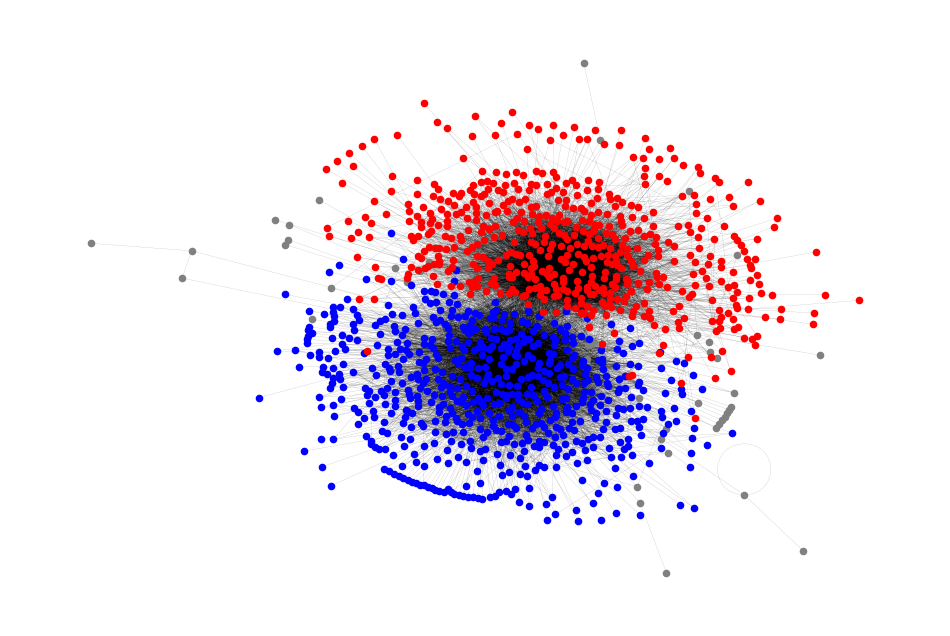

In [6]:
pos = nx.kamada_kawai_layout(Gt)

c1, c2 ,c3, c4, c5, c6, c7, c8, c9, c10 = best_partition

colors = ['gray', 'gray','gray','gray', 'gray','gray','gray', 'gray','blue','red']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(Gt, pos, width=0.05)

for community, color in zip(best_partition, colors):
    nx.draw_networkx_nodes(Gt, pos=pos, nodelist=community, node_color=color, node_size=20)
#nx.draw_networkx_labels(Gt, pos=pos)
_ = plt.axis('off')

#### 5.- Mire el archivo GML sin procesar y vea si puede adivinar qué es la red.

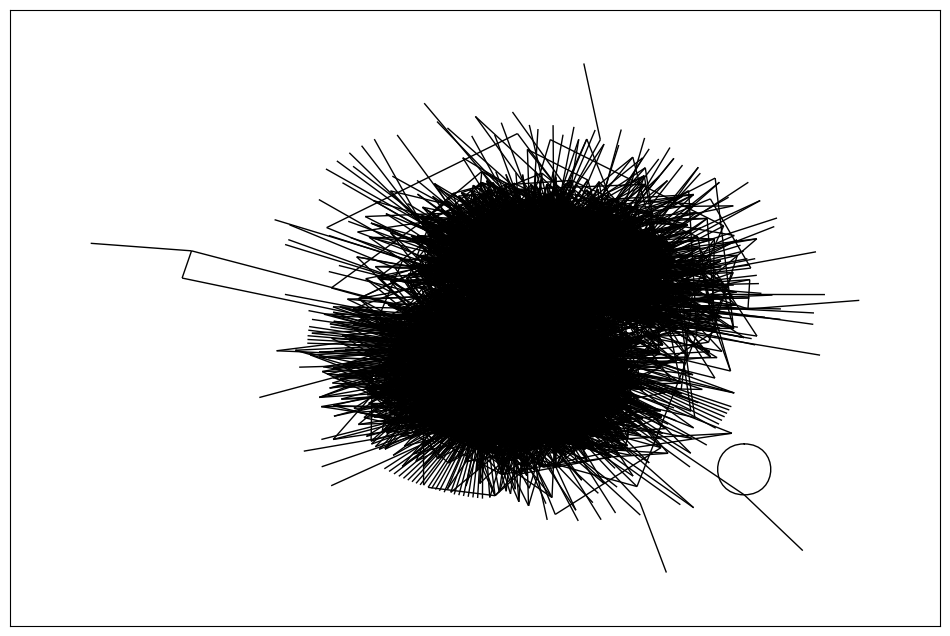

In [7]:
plt.figure(figsize=(12,8))
nx.draw_networkx_edges(Gt, pos)

In [8]:
edge_df = nx.to_pandas_edgelist(Gt) 

nodelist = list(Gt.nodes(data=True)) 
node_df = pd.DataFrame(nodelist, columns=['Node', 'name_attribute']) 
node_df

,Node,name_attribute
0,100monkeystyping.com,"{'value': 0, 'source': 'Blogarama', 'weight': ..."
1,12thharmonic.com/wordpress,"{'value': 0, 'source': 'BlogCatalog', 'weight'..."
2,750volts.blogspot.com,"{'value': 0, 'source': 'Blogarama', 'weight': ..."
3,95theses.blogspot.com,"{'value': 0, 'source': 'Blogarama', 'weight': ..."
4,abbadabbaduo.blogspot.com,"{'value': 0, 'source': 'Blogarama,LeftyDirecto..."
...,...,...
1217,youngconservative.blogspot.com,"{'value': 1, 'source': 'Blogarama', 'weight': ..."
1218,zebrax.blogs.com,"{'value': 1, 'source': 'BlogCatalog', 'weight'..."
1219,zeke01.blogspot.com,"{'value': 1, 'source': 'Blogarama,BlogCatalog'..."
1220,zeke01.typepad.com,"{'value': 1, 'source': 'Blogarama', 'weight': ..."


#### 6.- ¿Qué sospecha que representan los nodos "sobrantes"? (de nuevo, el archivo GML probablemente te pueda dar una pista si los buscas)

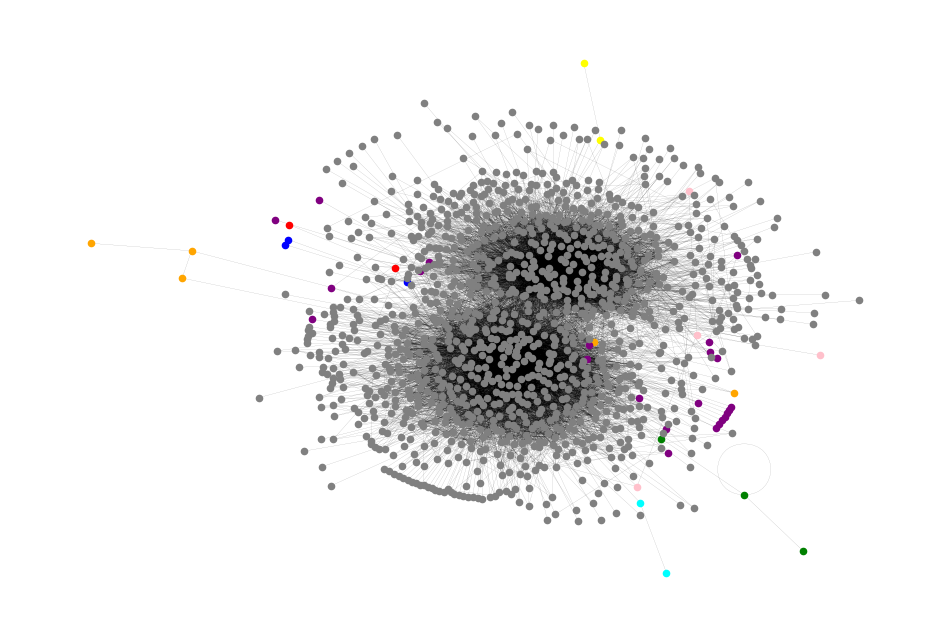

In [9]:
pos = nx.kamada_kawai_layout(Gt)

c1, c2 ,c3, c4, c5, c6, c7, c8, c9, c10 = best_partition

colors = ['cyan', 'yellow','red','blue', 'green','pink','orange', 'purple', 'gray', 'gray']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(Gt, pos, width=0.05)

for community, color in zip(best_partition, colors):
    nx.draw_networkx_nodes(Gt, pos=pos, nodelist=community, node_color=color, node_size=20)
#nx.draw_networkx_labels(Gt, pos=pos)
_ = plt.axis('off')

###### Respuesta

Se trata de comunidades que involucran nodos con un solo enlace y donde en general los nodos presentan un bajo grado de centralidad.

# Ejercicio 2 - Modularidad
***Instrucciones:***
1. Lea la documentación de la función NetworkX `nx.random_partition_graph` (https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.community.random_partition_graph.html)
2. Explique lo que hace este modelo.
3. Úselo para generar una red de cuatro comunidades, cada una con 25 nodos. Use `p_in = 0.5` y `p_out=0.01`.
4. Dibuja la red. Colorea los cuatro grupos de nodos usando los colores. `["red", "blue", "yellow", "green"]` siguiendo el ejemplo del club de karate de arriba.
5. ¿Cual esperas que sea la partición de esta red con la mayor modularidad? Ingrese manualmente y calcule su modularidad. En este modelo, los nodos son números enteros generados en orden por comunidad "natural", por ejemplo. 0, ..., 24 son la comunidad natural 1. Sugerencia: puede usar `list (range (i, j))` para obtener una lista de enteros entre `i` y` j-1` (inclusive).
6. Cree una partición que debería tener una modularidad que sea exactamente cero. Calcula su modularidad para verificar. Explique en términos de la ecuación de arriba.
7. Diseñe una partición que tenga modularidad negativa. Calcúlela. Expliquela en términos de la ecuación anterior.

#### 1.- Lea la documentación de la función NetworkX nx.random_partition_graph (https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.community.random_partition_graph.html)

![title](img/random_partition_graph.jpg)

#### 2.- Explique lo que hace este modelo

###### Respuesta:

Permite generar una red aleatoria  en base a una cantidad definida de comunidade, cada una con una cantidad definida de nodos. También es posible definir la probabilidad de enlases entre nodos dentro de una misma comunidad y la probabilidad de enlases entre comunidades.

#### 3.- Úselo para generar una red de cuatro comunidades, cada una con 25 nodos. Use p_in = 0.5 y p_out=0.01.

In [10]:
G = nx.random_partition_graph([25,25,25, 25],0.5,0.01)
partition = G.graph['partition']

#### 4.- Dibuja la red. Colorea los cuatro grupos de nodos usando los colores. ["red", "blue", "yellow", "green"] siguiendo el ejemplo del club de karate de arriba.

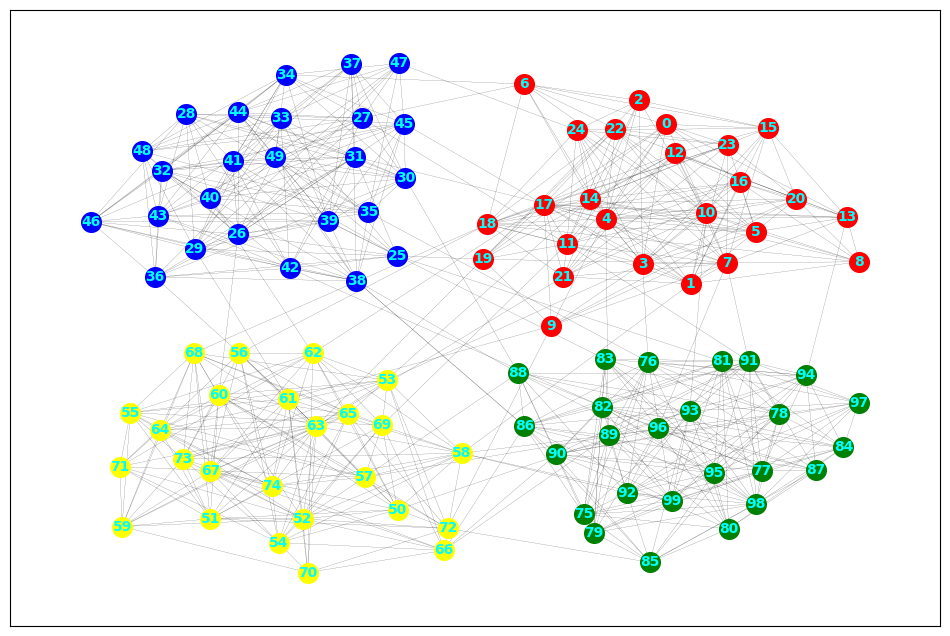

In [11]:
pos = nx.kamada_kawai_layout(G)

c1,c2,c3,c4 = partition
colors = ['red', 'blue', 'yellow', 'green']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(G, pos, width=0.1)

nx.draw_networkx_labels(G, pos=pos, font_color='cyan', font_size= 10, font_weight='black')

for community, color in zip(partition, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=200)



#### 5.- ¿Cual esperas que sea la partición de esta red con la mayor modularidad?  Ingrese manualmente y calcule su modularidad. En este modelo, los nodos son números enteros generados en orden por comunidad "natural", por ejemplo. 0, ..., 24 son la comunidad natural 1. Sugerencia: puede usar list (range (i, j)) para obtener una lista de enteros entre i yj-1 (inclusive).

In [12]:
c1 = list(range(0,50))
c2 = list(range(50,100))
partition = [c1, c2]
import networkx.algorithms.community as nx_comm
print(f'La mayor modularidad esperada es: {nx_comm.modularity(G, communities=partition)} ')

La mayor modularidad esperada es: 0.45430894082923845 


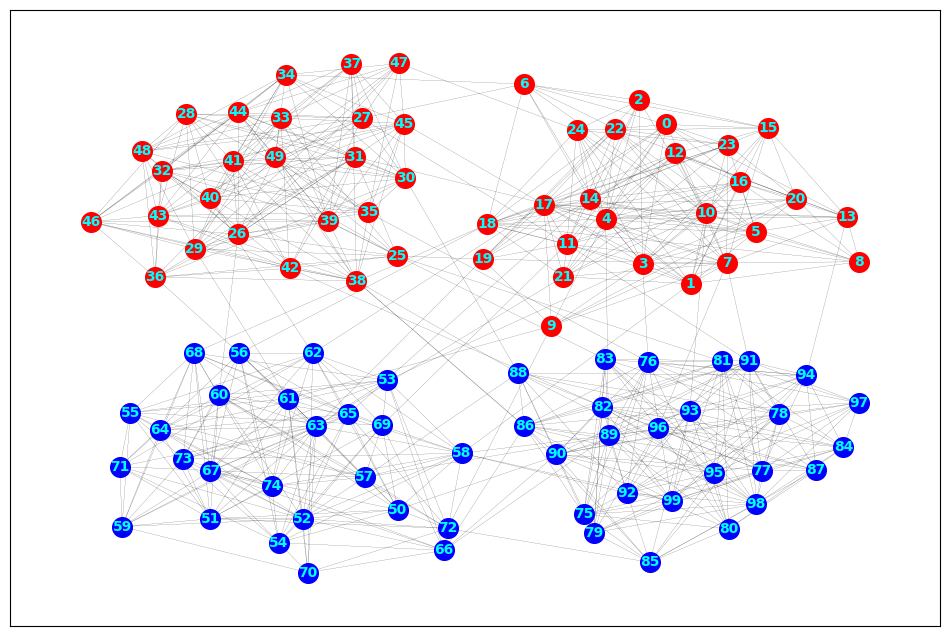

In [13]:
pos = nx.kamada_kawai_layout(G)

c1,c2 = partition
colors = ['red', 'blue']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(G, pos, width=0.1)

nx.draw_networkx_labels(G, pos=pos, font_color='cyan', font_size= 10, font_weight='black')

for community, color in zip(partition, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=200)

#### 6.- Cree una partición que debería tener una modularidad que sea exactamente cero. Calcula su modularidad para verificar. Explique en términos de la ecuación de arriba.

In [14]:
c1 = list(range(0,100))
c2 = list(range(100,100))
partition = [c1, c2]
import networkx.algorithms.community as nx_comm
print(f'La modularidad esperada es: {nx_comm.modularity(G, communities=partition)} ')

La modularidad esperada es: 0.0 


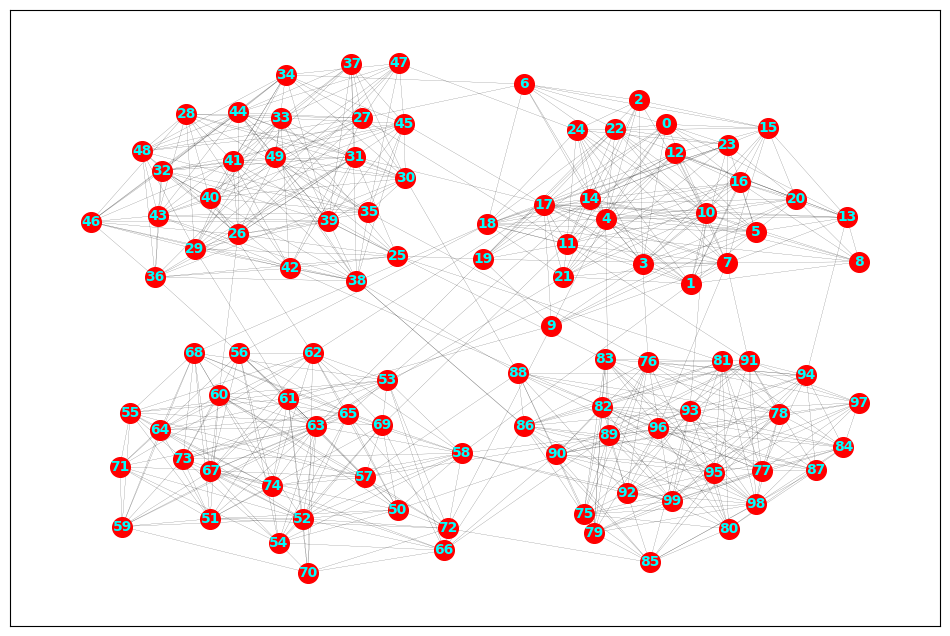

In [15]:
pos = nx.kamada_kawai_layout(G)

c1,c2 = partition
colors = ['red', 'blue']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(G, pos, width=0.1)

nx.draw_networkx_labels(G, pos=pos, font_color='cyan', font_size= 10, font_weight='black')

for community, color in zip(partition, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=200)

#### 7.- Diseñe una partición que tenga modularidad negativa. Calcúlela. Expliquela en términos de la ecuación anterior.

In [16]:
c1 = list(range(0,98))
c2 = list(range(98,99))
c3 = list(range(99,100))

partition = [c1, c2, c3]
import networkx.algorithms.community as nx_comm
print(f'La modularidad esperada es: {nx_comm.modularity(G, communities=partition)} ')

La modularidad esperada es: -0.0007830436303570763 


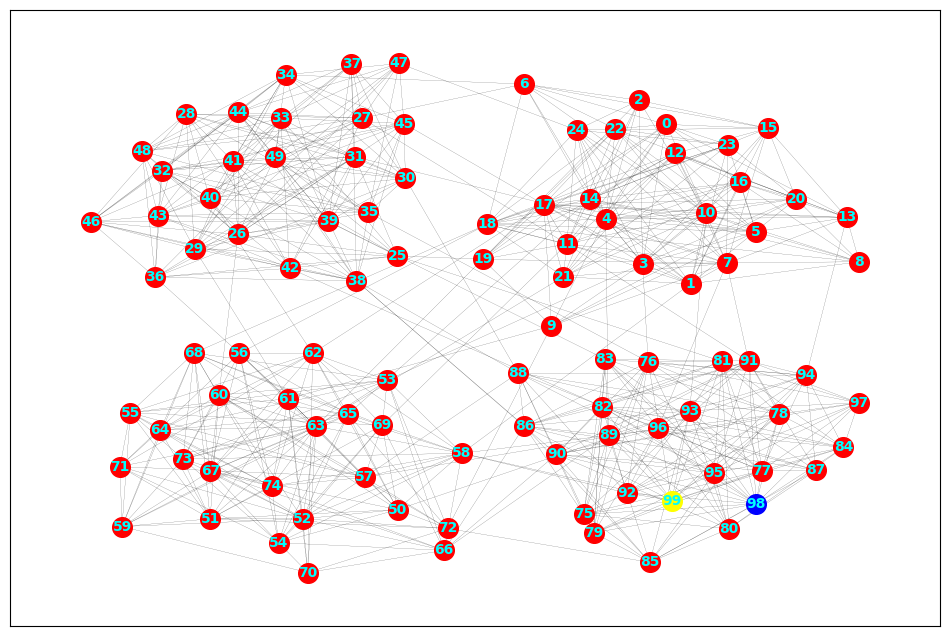

In [17]:
pos = nx.kamada_kawai_layout(G)

c1,c2,c3 = partition
colors = ['red', 'blue', 'yellow']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(G, pos, width=0.1)

nx.draw_networkx_labels(G, pos=pos, font_color='cyan', font_size= 10, font_weight='black')

for community, color in zip(partition, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=200)

# Ejercicio 3 - Modularidad en Redes Aleatorias
***Instrucciones:***
1. Reproducirá parte de la Figura 1b en el documento analizado adjunto, para S = 1000 nodos (usan S en lugar de N para el tamaño de la red en ese paper).

<img src="img/amaral.png" alt="Drawing" style="width: 400px;"/>


http://www.uvm.edu/pdodds/teaching/courses/2009-08UVM-300/docs/others/everything/guimera2004b.pdf


2. Escriba la función `er_max_modularity (k_avg)` que hace lo siguiente 10 veces: 

    a) genera un grafo aleatorio de ER con un grado promedio de k_avg, calcula la mejor partición de ese grafo usando el algoritmo fast greedy, luego registra su modularidad (construye una lista). La función debe devolver dos cosas: el promedio y la desviación estándar de los 10 valores de modularidad. P.ej. si ha llamado a su lista `Q`, devuelva ` np.mean (Q), np.std (Q) `
    
3. Genere una lista de 6 grados promedio espaciados logarítmicamente entre 2 y 10, llámela `K`.
4. Para cada grado promedio en 'K', use su función para calcular la media y la desviación estándar de la modularidad para un conjunto de redes ER con esa conectividad. Asígnelos a los arrays `mu` y` sigma`. 
5. Haz una gráfica de barras de error de tus resultados usando la desviación estándar de la modularidad como los "bigotes". Es decir, `plt.errorbar (K, mu, yerr = sigma)`. Configure la escala x para que sea logarítmica con `plt.gca (). Set_xscale ('log')`

#### 2.- Escriba la función er_max_modularity (k_avg) que hace lo siguiente 10 veces:

a) genera un grafo aleatorio de ER con un grado promedio de k_avg, calcula la mejor partición de ese grafo usando el algoritmo fast greedy, luego registra su modularidad (construye una lista). La función debe devolver dos cosas: el promedio y la desviación estándar de los 10 valores de modularidad. P.ej. si ha llamado a su lista Q, devuelva np.mean (Q), np.std (Q)

In [18]:
def er_max_modularity(N, k_avg):
    i = 0
    Grand_1 = nx.Graph()
    Grand_2 = nx.Graph()
    Grand_3 = nx.Graph()
    Grand_4 = nx.Graph()
    Grand_5 = nx.Graph()
    Grand_6 = nx.Graph()
    Grand_7 = nx.Graph()
    Grand_8 = nx.Graph()
    Grand_9 = nx.Graph()
    Grand_10 = nx.Graph()
    
    Grand_m = [Grand_1, Grand_2, Grand_3, Grand_4, Grand_5, Grand_6, Grand_7, Grand_8, Grand_9, Grand_10]
    while i < 10:
        
        # k_avg = 2*L/N
        L  = k_avg*N/2
        Lmax = N*(N-1)/2
        Pc = L/Lmax
        G_rand=nx.erdos_renyi_graph(N,Pc)
        if 2*G_rand.number_of_edges()/G_rand.number_of_nodes() == k_avg:
            Grand_m[i]=nx.erdos_renyi_graph(N,Pc)
            i = i+1
            
    #Ploteo de Grafos
    #for i in range(0,10):
        #plt.figure(figsize=(4,4))
        #nx.draw_networkx_edges(Grand_m[i], pos)
    
    list_Q = list()
    for i in range(0,10):
        best_partition, Q = fast_greedy(Grand_m[i])
        list_Q.append(Q)
        #print(best_partition, Q)
    Q_std = np.std (list_Q)
    Q_mean = np.mean(list_Q)
    Columns=['Modularidad']
    Q_df = pd.DataFrame(list_Q, columns = Columns)
    print(f'Lista de Modularidades:\n {Q_df} \n\nModularidad Promedio: {Q_mean} \n\nDesviación Estandar: {Q_std}')
    return Q_mean, Q_std

In [19]:
k_avg = 6
N = 100
er_max_modularity(N, k_avg)

Lista de Modularidades:
    Modularidad
0     0.333164
1     0.363552
2     0.350844
3     0.350009
4     0.328161
5     0.364489
6     0.326729
7     0.352158
8     0.335857
9     0.357411 

Modularidad Promedio: 0.34623736258888305 

Desviación Estandar: 0.013469440037519985


(0.34623736258888305, 0.013469440037519985)

#### 3.- Genere una lista de 6 grados promedio espaciados logarítmicamente entre 2 y 10, llámela K.

In [20]:
K = list(np.logspace(np.log10(2), np.log10(10), num=6))
K

[2.0,
 2.75945932292243,
 3.807307877431757,
 5.253055608807535,
 7.247796636776954,
 10.0]

#### 4.- Para cada grado promedio en 'K', use su función para calcular la media y la desviación estándar de la modularidad para un conjunto de redes ER con esa conectividad. Asígnelos a los arrays mu ysigma.

In [21]:
N = 100
mu = list()
sigma = list()
for i in range(0,6):
    K[i] = round(K[i], 1)
    print(K[i])
    if (K[i]*10%2) != 0:
        K[i] = (K[i]*10-1)/10
        
    mu_m, sigma_m = er_max_modularity(N, K[i])
    mu.append(mu_m)
    sigma.append(sigma_m)
print(f'Lista mu :\n\n{pd.DataFrame(mu).transpose()}\n\n')
print(f'Lista sigma :\n\n{pd.DataFrame(sigma).transpose()}\n\n')


2.0
Lista de Modularidades:
    Modularidad
0     0.645155
1     0.701647
2     0.643885
3     0.757885
4     0.687548
5     0.680519
6     0.697687
7     0.660100
8     0.683508
9     0.742778 

Modularidad Promedio: 0.69007119213862 

Desviación Estandar: 0.03571876526557066
2.8
Lista de Modularidades:
    Modularidad
0     0.568439
1     0.620529
2     0.553103
3     0.614421
4     0.558207
5     0.525559
6     0.530034
7     0.591450
8     0.544490
9     0.484588 

Modularidad Promedio: 0.5590819720791406 

Desviación Estandar: 0.03967355895358446
3.8
Lista de Modularidades:
    Modularidad
0     0.453247
1     0.473296
2     0.501418
3     0.496703
4     0.440681
5     0.504892
6     0.453118
7     0.517520
8     0.480845
9     0.504376 

Modularidad Promedio: 0.4826097559173033 

Desviación Estandar: 0.02514190208452661
5.3
Lista de Modularidades:
    Modularidad
0     0.384281
1     0.379593
2     0.415530
3     0.429144
4     0.394784
5     0.398897
6     0.369106
7     0.36564

#### 5.- Haz una gráfica de barras de error de tus resultados usando la desviación estándar de la modularidad como los "bigotes". Es decir, plt.errorbar (K, mu, yerr = sigma). Configure la escala x para que sea logarítmica con plt.gca (). Set_xscale ('log')

<ErrorbarContainer object of 3 artists>

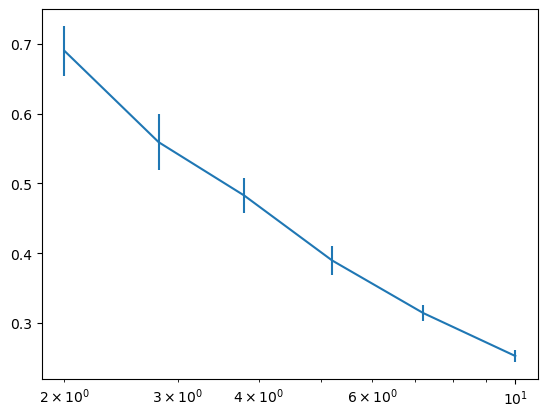

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.errorbar (K, mu, yerr = sigma)

<ErrorbarContainer object of 3 artists>

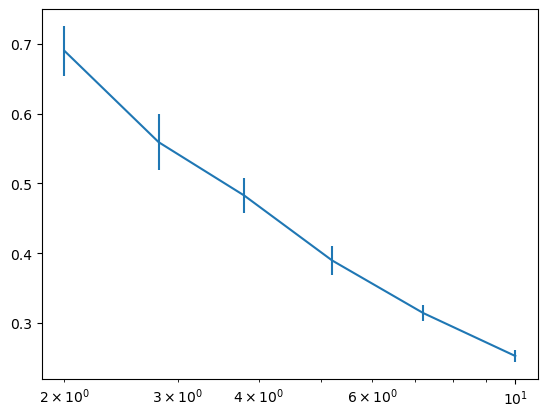

In [31]:

plt.gca().set_xscale('log')
plt.errorbar (K, mu, yerr = sigma)